Stochastic Variational Optimization with SVIGP
--

Pytorch adaptation of test_svi Notebook by *Mark van der Wilk, 2016*, *edits by James Hensman, 2016*

*Pytorch version by Thomas Viehmann*

In [1]:
import sys, os
import numpy
import time
sys.path.append(os.path.join(os.getcwd(),'..'))

import candlegp
from matplotlib import pyplot
import torch
from torch.autograd import Variable
%matplotlib inline
pyplot.style.use('ggplot')
import IPython

In [2]:
M = 50

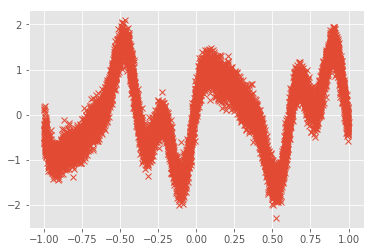

In [3]:
def func(x):
    return torch.sin(x * 3*3.14) + 0.3*torch.cos(x * 9*3.14) + 0.5 * torch.sin(x * 7*3.14)
X = torch.rand(10000, 1).double() * 2 - 1
Y = func(X) + torch.randn(10000, 1).double() * 0.2
pyplot.plot(X.numpy(), Y.numpy(), 'x')
D = X.size(1)
Xt = torch.linspace(-1.1, 1.1, 100).double().unsqueeze(1)
Yt = func(Xt)

In [4]:
k = candlegp.kernels.RBF(D,variance=torch.DoubleTensor([1.0])).double()
Z = X[:M].clone()
m = candlegp.models.SVGP(Variable(X), Variable(Y.unsqueeze(1)),
                         likelihood=candlegp.likelihoods.Gaussian(ttype=torch.DoubleTensor),
                         kern=k, Z=Z)
m

Parameter,Value,Prior,ParamType
Z,[[ 0.63010442] [-0.79012716] [ 0.60516071] [ 0.97405493] [ 0.49361312] [-0.91824734] [ 0.64536035] [ 0.50011456] [-0.34616864] [-0.0408175 ] [-0.09994948] [ 0.85445106] [ 0.79699075] [-0.48120224] [-0.84617746] [-0.65778577] [ 0.06404901] [ 0.82999408] [ 0.21822274] [ 0.99332821] [-0.79720736] [-0.51157713] [ 0.30289233] [ 0.63893735] [-0.26428235] [-0.952721 ] [ 0.01664805] [ 0.35411799] [ 0.32761872] [-0.83985472] [-0.02740657] [-0.68537796] [-0.39533782] [-0.18691576] [-0.35851753] [-0.00333714] [ 0.22383416] [ 0.05299091] [ 0.62283623] [ 0.16650891] [ 0.7686193 ] [ 0.88054776] [-0.15809071] [ 0.68349195] [ 0.75121939] [-0.2480247 ] [-0.10836625] [-0.99080086] [ 0.85835981] [ 0.72025025]],None,Param
q_mu,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],None,Param
q_sqrt,"[[[ 1.] [ 0.] [ 0.] ..., [ 0.] [ 0.] [ 0.]] [[ 0.] [ 1.] [ 0.] ..., [ 0.] [ 0.] [ 0.]] [[ 0.] [ 0.] [ 1.] ..., [ 0.] [ 0.] [ 0.]] ..., [[ 0.] [ 0.] [ 0.] ..., [ 1.] [ 0.] [ 0.]] [[ 0.] [ 0.] [ 0.] ..., [ 0.] [ 1.] [ 0.]] [[ 0.] [ 0.] [ 0.] ..., [ 0.] [ 0.] [ 1.]]]",None,LowerTriangularParam
kern.variance,[ 1.],None,PositiveParam
kern.lengthscales,[ 0.99999996],None,PositiveParam
likelihood.variance,[ 1.],None,PositiveParam


### Stochastical estimation of ELBO
The minibatch estimate should be an unbiased estimator of the `ground_truth`. Here we show a histogram of the value from different evaluations, together with its mean and the ground truth. The small difference between the mean of the minibatch estimations and the ground truth shows that the minibatch estimator is working as expected.

In [5]:
# ground_truth = m.compute_log_likelihood() # seems to take too long
evals = []
for i in range(100):
    if i % 10 == 9:
        print ('.', end='')
    idxes = torch.randperm(X.size(0))[:100]
    evals.append(m.compute_log_likelihood(Variable(X[idxes]), Variable(Y[idxes])).data[0])


..........

(array([  2.,   3.,   8.,  11.,  22.,  20.,  15.,  14.,   4.,   1.]),
 array([-18639.50703082, -18460.6436115 , -18281.78019218, -18102.91677287,
        -17924.05335355, -17745.18993423, -17566.32651491, -17387.46309559,
        -17208.59967627, -17029.73625695, -16850.87283763]),
 <a list of 10 Patch objects>)

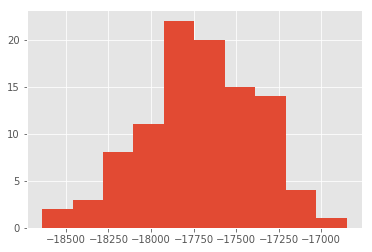

In [6]:
pyplot.hist(evals)
#pyplot.axvline(ground_truth)

### Minibatches speed up computation
The use of using minibatches is that it decreases the time needed to make an optimisation step, since estmating the objective is cheaper. Here we plot the change in time required with the size of the minibatch. We see that smaller minibatches result in a cheaper estimate of the objective.

In [7]:
mbps = numpy.logspace(-2, -0.8, 7)
times = []
objs = []
for mbp in mbps:
    minibatch_size = int(len(X) * mbp)
    print (minibatch_size)
    start_time = time.time()
    evals = []
    
    for i in range(20):
        idxes = torch.randperm(X.size(0))[:minibatch_size]
        evals.append(m.compute_log_likelihood(Variable(X[idxes]), Variable(Y[idxes])).data[0])
    objs.append(evals)

#    plt.hist(objs, bins = 100)
#    plt.axvline(ground_truth, color='r')
    times.append(time.time() - start_time)

100
158
251
398
630
1000
1584


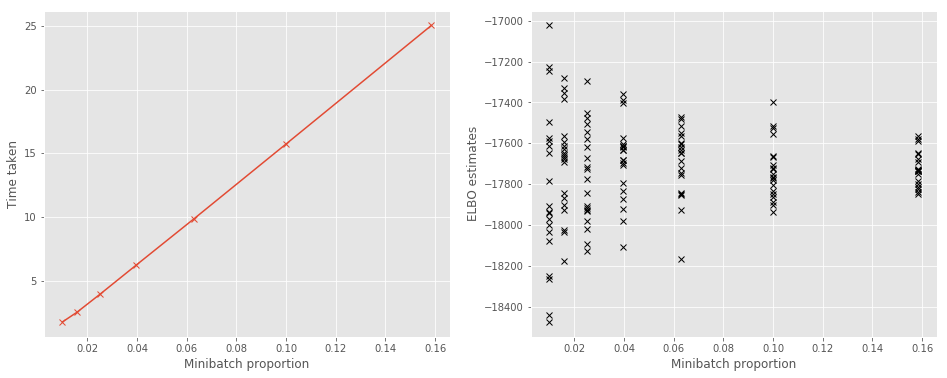

In [8]:
f, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(16, 6))
ax1.plot(mbps, times, 'x-')
ax1.set_xlabel("Minibatch proportion")
ax1.set_ylabel("Time taken")

ax2.plot(mbps, numpy.array(objs), 'kx')
ax2.set_xlabel("Minibatch proportion")
ax2.set_ylabel("ELBO estimates")



### Running stochastic optimization

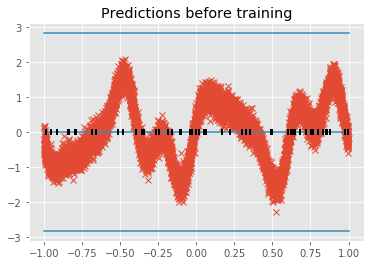

In [9]:
pX = Variable(torch.linspace(-1, 1, 100).unsqueeze(1).double())
pY, pYv = m.predict_y(pX)
pyplot.plot(X.numpy(), Y.numpy(), 'x')
line, = pyplot.plot(pX.data.numpy(), pY.data.numpy(), lw=1.5)
col = line.get_color()
pyplot.plot(pX.data.numpy(), (pY+2*pYv**0.5).data.numpy(), col, lw=1.5)
pyplot.plot(pX.data.numpy(), (pY-2*pYv**0.5).data.numpy(), col, lw=1.5)
pyplot.plot(m.Z.get().data.numpy(), numpy.zeros(m.Z.shape), 'k|', mew=2)
pyplot.title("Predictions before training")


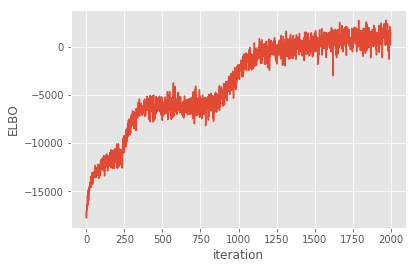

In [10]:
logt = []
logf = []

st = time.time()
minibatch_size = 100
m.Z.requires_grad = True
opt = torch.optim.Adam(m.parameters(), lr=0.01)
m.Z.requires_grad = False

for i in range(2000):
    if i % 50 == 49:
        print (i)
    idxes = torch.randperm(X.size(0))[:minibatch_size]
    opt.zero_grad()
    obj = m(Variable(X[idxes]), Variable(Y[idxes]))
    logf.append(obj.data[0])
    obj.backward()
    opt.step()
    logt.append(time.time() - st)
    if i%50 == 49:
        IPython.display.clear_output(True)
        pyplot.plot(-numpy.array(logf))
        pyplot.xlabel('iteration')
        pyplot.ylabel('ELBO')
        pyplot.show()

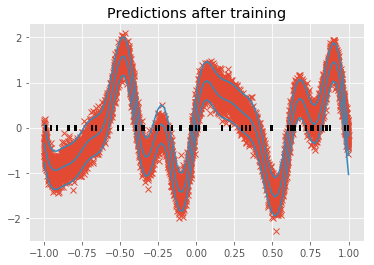

In [11]:
pX = Variable(torch.linspace(-1, 1, 100).unsqueeze(1).double())
pY, pYv = m.predict_y(pX)
pyplot.plot(X.numpy(), Y.numpy(), 'x')
line, = pyplot.plot(pX.data.numpy(), pY.data.numpy(), lw=1.5)
col = line.get_color()
pyplot.plot(pX.data.numpy(), (pY+2*pYv**0.5).data.numpy(), col, lw=1.5)
pyplot.plot(pX.data.numpy(), (pY-2*pYv**0.5).data.numpy(), col, lw=1.5)
pyplot.plot(m.Z.get().data.numpy(), numpy.zeros(m.Z.shape), 'k|', mew=2)
pyplot.title("Predictions after training")